## BATCH aligner

#### Introduction

In metabolomics and natural product research, it is crucial to ensure that features detected across multiple batches of mass spectrometry (MS) data are accurately aligned and comparable. This notebook provides a comprehensive workflow for aligning MS features across different batches, focusing on interbatch comparison and annotation of compounds. The method is designed specifically for features that include MS/MS data, which allows for a more precise and reliable alignment process.

#### Objectives

##### The primary goals of this notebook are:

* Feature Alignment: Align MS features from multiple batches based on retention time (RT) and mass-to-charge ratio (m/z) thresholds.
* Cosine Similarity Calculation: Filter aligned features by computing the cosine similarity between their MS/MS spectra to ensure they are indeed similar.
* Visualization: Plot and visualize the aligned features to facilitate further analysis and validation.

#### Methodology

##### The notebook is structured to perform the following key steps:

1. Data Import and Setup: Read MS feature data from .csv files corresponding to different batches and set up the necessary environment for processing.

Data Requirements:

    1. Process each batch using MZMine accordingly.
    2. Export the aligned feature list for applying the exported data to:
        (a) GNPS-FBMN (xxxx_quant.csv + xxxx.mgf)
        (b) MetaboAnalyst (xxxx_MetaboAnalyst.csv)
    3. Name the exported files as follows: xxxx_batch#.mgf, xxxx_batch#.csv, xxxx_batch#_MetaboAnalyst.csv
        xxxx is the "project name" (e.g., "PHerb1"), and # refers to the batch number.


2. Feature Alignment: Use the align_features function to merge features from different batches based on predefined RT and m/z thresholds.
3. Cosine Similarity Filtering: Apply the calculate_cosine_similarity function to compare MS/MS spectra of aligned features, retaining only those with high similarity.
4. Visualization: Utilize plotting functions to visualize the spectra of aligned features, both for specific scan numbers and for randomly selected features.

#### Notes

* Scope: This method focuses exclusively on features with MS/MS data, as those without MS/MS data are outside the scope of this alignment approach.
* Application: The alignment and visualization techniques provided here are tailored for applications in natural products and metabolomics research, where accurate interbatch comparison is essential.

---
#### Import the necessary libraries for data manipulation, computation, and visualization.


In [1]:
from alignment_functions import * #parse_mgf_files, extract_values_and_create_dfs, align_features, calculate_cosine_similarity, filter_aligned_features, plot_ms_spectra, plot_random_ms_spectra

---

In [8]:
# Directory containing .mgf files and related MetaboAnalyst.csv files
directory_path = r'C:\Users\PC Lab\Edison_Lab@UGA Dropbox\Ricardo Borges\Projeto_herbarium\Andrew Lab\Projeto herbário\MSMS - Amostras\Projeto_alinhamento\Processamento_romulo\batches'

# Define the project
project_prefix = "PHerb1_"

# Align features across batches with selected mz_threshold and rt_threshold values
mz_threshold = 0.02
rt_threshold = 0.4
cosine_threshold = 0.95

---
#### Parse the .mgf Files

This sets up the directory path for the MGF and MetaboAnalyst.csv files and defines a function to parse the MGF files. Follow these steps:

The parse_mgf_files function manually reads each MGF file, extracts the spectra data, and stores it in a dictionary. The purpose is to load and verify the spectral data from the MGF files for further analysis.

In [9]:
# Parse .mgf files to get spectra
spectra = parse_mgf_files(directory_path)

# Verify that the spectra have been loaded correctly
for batch_name, batch_spectra in spectra.items():
    print(f"Batch: {batch_name}, Number of spectra: {len(batch_spectra)}")

Processing MGF file: C:\Users\PC Lab\Edison_Lab@UGA Dropbox\Ricardo Borges\Projeto_herbarium\Andrew Lab\Projeto herbário\MSMS - Amostras\Projeto_alinhamento\Processamento_romulo\batches\PHerb1_1-1-romulo.mgf
Processing MGF file: C:\Users\PC Lab\Edison_Lab@UGA Dropbox\Ricardo Borges\Projeto_herbarium\Andrew Lab\Projeto herbário\MSMS - Amostras\Projeto_alinhamento\Processamento_romulo\batches\PHerb1_1-2-romulo.mgf
Processing MGF file: C:\Users\PC Lab\Edison_Lab@UGA Dropbox\Ricardo Borges\Projeto_herbarium\Andrew Lab\Projeto herbário\MSMS - Amostras\Projeto_alinhamento\Processamento_romulo\batches\PHerb1_2-1-romulo.mgf
Processing MGF file: C:\Users\PC Lab\Edison_Lab@UGA Dropbox\Ricardo Borges\Projeto_herbarium\Andrew Lab\Projeto herbário\MSMS - Amostras\Projeto_alinhamento\Processamento_romulo\batches\PHerb1_2-2-romulo.mgf
Batch: PHerb1_1-1-romulo, Number of spectra: 908
Batch: PHerb1_1-2-romulo, Number of spectra: 595
Batch: PHerb1_2-1-romulo, Number of spectra: 374
Batch: PHerb1_2-2-rom

---
#### Extract Values and Create DataFrames from .csv Files

This step reads the MetaboAnalyst.csv files, extracts the relevant data, and creates a DataFrame for each file.

    1. Process each file to extract scan numbers, mz values, and rt values.
    2. Handle missing data by replacing NaN values with 0.
    3. Convert data types appropriately for analysis.
    4. Add batch information to each DataFrame.

* The function extract_values_and_create_dfs reads _MetaboAnalyst.csv files from the specified directory, extracting key information such as scan_number, mz_value, rt_value, and the batch identifier.
* The first row of each batch, which contains classification information, is excluded from the alignment process but saved for future use.

The processed DataFrames are stored in a dictionary for further analysis.

In [10]:
# Find all _MetaboAnalyst.csv files in the directory
file_paths = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('_MetaboAnalyst.csv')]

# Create separate DataFrames for each file and save first rows
dfs, first_rows = extract_values_and_create_dfs(file_paths)

# Display the first few rows of each DataFrame and the first rows
for name, df in dfs.items():
    print(f"{name}:")
    display(df)

print("First rows for classification:")
#for name, row in first_rows.items():
    #print(f"{name}: {row}")

df_PHerb1_1-1-romulo:


,scan_number,mz_value,rt_value,batch,feature_batch,Filename,6.mzML,16.mzML,12.mzML,13.mzML,...,33.mzML,31.mzML,53.mzML,41.mzML,45.mzML,48.mzML,MPCQExt.mzML,CQExt_20231024173747.mzML,CQExt.mzML,CQExt_20231024150135.mzML
1,1,151.0355,0.21,PHerb1_1-1-romulo,1_PHerb1_1-1-romulo,1/151.0355mz/0.21min,1559816.5,2542374.5,765244.625,2182983.75,...,980111.6875,0,260038.859375,307575.3125,1095140.0,0,310584.71875,419492.875,0,433144.96875
2,2,83.5361,0.21,PHerb1_1-1-romulo,2_PHerb1_1-1-romulo,2/83.5361mz/0.21min,0,665364.5625,0,438936.5,...,0,0,0,0,0,0,0,0,0,0
3,3,153.0331,0.21,PHerb1_1-1-romulo,3_PHerb1_1-1-romulo,3/153.0331mz/0.21min,0,289347.4375,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,241.9999,0.21,PHerb1_1-1-romulo,4_PHerb1_1-1-romulo,4/241.9999mz/0.21min,644490.8125,1089360.125,0,1040891.9375,...,0,503821.78125,0,0,0,0,0,0,0,0
5,5,130.0174,0.21,PHerb1_1-1-romulo,5_PHerb1_1-1-romulo,5/130.0174mz/0.21min,0,343931.6875,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,1167,413.3772,7.40,PHerb1_1-1-romulo,1167_PHerb1_1-1-romulo,1167/413.3772mz/7.40min,0,0,0,75069.578125,...,0,0,0,0,0,0,0,0,0,0
1164,1168,413.3774,7.41,PHerb1_1-1-romulo,1168_PHerb1_1-1-romulo,1168/413.3774mz/7.41min,96374.15625,0,0,41207.1328125,...,0,0,0,0,0,0,0,0,0,0
1165,1169,413.3773,7.42,PHerb1_1-1-romulo,1169_PHerb1_1-1-romulo,1169/413.3773mz/7.42min,89831.6875,0,0,299318.125,...,0,0,0,0,0,0,0,0,0,0
1166,1170,413.3774,7.43,PHerb1_1-1-romulo,1170_PHerb1_1-1-romulo,1170/413.3774mz/7.43min,76735.546875,0,0,83304.6484375,...,0,0,0,0,0,0,0,0,0,0


df_PHerb1_1-2-romulo:


,scan_number,mz_value,rt_value,batch,feature_batch,Filename,5.mzML,1.mzML,4.mzML,8.mzML,...,63.mzML,59.mzML,60.mzML,MPCQExt_20231024174844.mzML,64.mzML,MPCQExt_20231025023336.mzML,MPCQExt_20231024230550.mzML,CQExt_20231025022239.mzML,CQExt_20231024225453.mzML,CQExt_20231024202144.mzML
1,1,195.0886,0.06,PHerb1_1-2-romulo,1_PHerb1_1-2-romulo,1/195.0886mz/0.06min,0,0,0,0,...,0,0,0,0,0,0,81378.5859375,0,0,0
2,2,195.0888,0.10,PHerb1_1-2-romulo,2_PHerb1_1-2-romulo,2/195.0888mz/0.10min,0,0,0,0,...,0,0,0,0,0,0,150160.46875,0,0,0
3,3,195.0886,0.18,PHerb1_1-2-romulo,3_PHerb1_1-2-romulo,3/195.0886mz/0.18min,0,0,0,0,...,0,0,0,0,0,0,175124.15625,0,0,0
4,4,265.0162,0.21,PHerb1_1-2-romulo,4_PHerb1_1-2-romulo,4/265.0162mz/0.21min,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,82.0141,0.21,PHerb1_1-2-romulo,5_PHerb1_1-2-romulo,5/82.0141mz/0.21min,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,742,411.3639,7.24,PHerb1_1-2-romulo,742_PHerb1_1-2-romulo,742/411.3639mz/7.24min,0,0,0,56352.2421875,...,0,0,0,0,0,0,0,0,0,0
743,743,411.3641,7.24,PHerb1_1-2-romulo,743_PHerb1_1-2-romulo,743/411.3641mz/7.24min,0,0,0,143955.578125,...,0,0,0,0,0,0,0,0,0,0
744,744,413.3774,7.42,PHerb1_1-2-romulo,744_PHerb1_1-2-romulo,744/413.3774mz/7.42min,124312.8828125,0,0,194407.6875,...,0,0,0,0,115147.828125,0,0,0,0,0
745,745,413.3774,7.42,PHerb1_1-2-romulo,745_PHerb1_1-2-romulo,745/413.3774mz/7.42min,0,0,0,218057.40625,...,0,0,0,0,86970.8828125,0,0,0,0,0


df_PHerb1_2-1-romulo:


,scan_number,mz_value,rt_value,batch,feature_batch,Filename,71.mzML,80.mzML,74.mzML,68.mzML,...,123.mzML,118.mzML,117.mzML,124.mzML,MPCQExt_20231025030633 - Copia.mzML,128.mzML,MPCQExt_20231025062315.mzML,CQExt_20231025025536.mzML,CQExt_20231025061218.mzML,CQExt_20231025085618.mzML
1,1,118.0866,0.12,PHerb1_2-1-romulo,1_PHerb1_2-1-romulo,1/118.0866mz/0.12min,193351.09375,0,0,0,...,0,352903.6875,4.9945396E7,0,0,0,0,0,0,0
2,2,195.0878,0.17,PHerb1_2-1-romulo,2_PHerb1_2-1-romulo,2/195.0878mz/0.17min,0,0,0,0,...,0,0,0,0,408071.40625,0,431535.8125,0,0,0
3,3,128.0196,0.21,PHerb1_2-1-romulo,3_PHerb1_2-1-romulo,3/128.0196mz/0.21min,0,1541039.5,1558578.0,3596150.25,...,0,1649520.875,429256.40625,0,217848.9375,0,218535.609375,445843.84375,488072.125,482491.625
4,4,151.0355,0.21,PHerb1_2-1-romulo,4_PHerb1_2-1-romulo,4/151.0355mz/0.21min,0,1159861.875,0,2486579.25,...,0,1218211.0,368899.5,0,0,0,176627.5625,412499.875,430977.0625,389464.90625
5,5,110.0090,0.21,PHerb1_2-1-romulo,5_PHerb1_2-1-romulo,5/110.0090mz/0.21min,0,1033674.0625,0,2023148.25,...,0,1074343.75,352389.1875,0,0,0,140316.875,367024.375,335143.28125,331602.03125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,476,107.0607,7.41,PHerb1_2-1-romulo,476_PHerb1_2-1-romulo,476/107.0607mz/7.41min,0,0,0,236530.34375,...,0,0,0,0,0,0,0,0,0,0
472,477,149.0825,7.51,PHerb1_2-1-romulo,477_PHerb1_2-1-romulo,477/149.0825mz/7.51min,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
473,478,174.0905,7.55,PHerb1_2-1-romulo,478_PHerb1_2-1-romulo,478/174.0905mz/7.55min,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
474,479,124.0874,7.56,PHerb1_2-1-romulo,479_PHerb1_2-1-romulo,479/124.0874mz/7.56min,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df_PHerb1_2-2-romulo:


,scan_number,mz_value,rt_value,batch,feature_batch,Filename,73.mzML,85.mzML,78.mzML,75.mzML,...,125.mzML,MPCQExt_20231025090714.mzML,127.mzML,122.mzML,109.mzML,CQExt_20231027161607.mzML,MPCQExt_20231025030633.mzML,CQExt_20231027134303.mzML,CQExt_20231027105901.mzML,MPCQExt_20231027110958.mzML
1,1,118.0865,0.02,PHerb1_2-2-romulo,1_PHerb1_2-2-romulo,1/118.0865mz/0.02min,0,0,186196.921875,0,...,0,0,0,0,0,0,0,0,0,0
2,2,118.0864,0.12,PHerb1_2-2-romulo,2_PHerb1_2-2-romulo,2/118.0864mz/0.12min,0,0,0,0,...,0,0,0,0,244316.09375,0,0,0,0,0
3,3,195.0877,0.18,PHerb1_2-2-romulo,3_PHerb1_2-2-romulo,3/195.0877mz/0.18min,0,0,0,0,...,0,0,0,0,0,0,408071.40625,0,0,0
4,4,118.0867,0.19,PHerb1_2-2-romulo,4_PHerb1_2-2-romulo,4/118.0867mz/0.19min,0,0,0,0,...,0,0,0,0,0,0,0,78828.8671875,0,0
5,5,128.0197,0.20,PHerb1_2-2-romulo,5_PHerb1_2-2-romulo,5/128.0197mz/0.20min,0,0,0,0,...,0,0,0,0,0,0,0,0,383171.28125,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,771,124.0874,7.63,PHerb1_2-2-romulo,771_PHerb1_2-2-romulo,771/124.0874mz/7.63min,0,0,0,0,...,0,0,0,0,0,0,0,0,0,339212.28125
709,773,107.0608,7.70,PHerb1_2-2-romulo,773_PHerb1_2-2-romulo,773/107.0608mz/7.70min,0,0,0,0,...,0,0,0,0,0,0,0,0,0,807292.625
710,775,124.0874,7.77,PHerb1_2-2-romulo,775_PHerb1_2-2-romulo,775/124.0874mz/7.77min,0,0,0,0,...,0,0,0,0,0,0,0,0,380692.34375,0
711,776,124.0874,7.87,PHerb1_2-2-romulo,776_PHerb1_2-2-romulo,776/124.0874mz/7.87min,0,0,0,0,...,0,0,0,0,0,0,0,0,489055.21875,0


First rows for classification:


---
### Align Features according to Retention Time and M/Z values

* The align_features function aligns features across batches by comparing mz_value and rt_value with specified thresholds (mz_threshold and rt_threshold).
* Features are matched and grouped together if their m/z and RT values fall within the defined thresholds.
* Intensities of matched features are combined, and an aligned_features column is created to indicate which features from different batches have been aligned.


In [11]:
# Align features across batches
aligned_rt_mz_df = align_features(dfs, mz_threshold=mz_threshold, rt_threshold=rt_threshold)

# Create the subdirectory if it doesn't exist
if not os.path.exists(os.path.join(directory_path, 'alignment_info_df')):
    os.makedirs(os.path.join(directory_path, 'alignment_info_df'))

# Save the modified DataFrame to the new subdirectory
output_file_path = os.path.join(os.path.join(directory_path, 'alignment_info_df'), 'aligned_rt_mz_df.csv')
aligned_rt_mz_df.to_csv(output_file_path, index=False)

# Display the aligned features DataFrame
pd.set_option("max_colwidth", None)
display(aligned_rt_mz_df)
#display(aligned_features_df[["scan_number", "mz_value", "rt_value", "feature_batch", "aligned_features"]])

,scan_number,mz_value,rt_value,feature_batch,aligned_features,df_PHerb1_1-1-romulo_feature_batch,df_PHerb1_1-1-romulo_Filename,df_PHerb1_1-1-romulo_6.mzML,df_PHerb1_1-1-romulo_16.mzML,df_PHerb1_1-1-romulo_12.mzML,...,df_PHerb1_2-2-romulo_125.mzML,df_PHerb1_2-2-romulo_MPCQExt_20231025090714.mzML,df_PHerb1_2-2-romulo_127.mzML,df_PHerb1_2-2-romulo_122.mzML,df_PHerb1_2-2-romulo_109.mzML,df_PHerb1_2-2-romulo_CQExt_20231027161607.mzML,df_PHerb1_2-2-romulo_MPCQExt_20231025030633.mzML,df_PHerb1_2-2-romulo_CQExt_20231027134303.mzML,df_PHerb1_2-2-romulo_CQExt_20231027105901.mzML,df_PHerb1_2-2-romulo_MPCQExt_20231027110958.mzML
0,2,83.5361,0.21,2_PHerb1_1-1-romulo,2_PHerb1_1-1-romulo; 11_PHerb1_1-2-romulo; 7_PHerb1_2-1-romulo; 18_PHerb1_2-2-romulo; 37_PHerb1_2-2-romulo,2_PHerb1_1-1-romulo,2/83.5361mz/0.21min,0,665364.5625,0,...,0,0,0,0,0,0,0,0,0,0
1,3,153.0331,0.21,3_PHerb1_1-1-romulo,3_PHerb1_1-1-romulo; 231_PHerb1_1-1-romulo; 236_PHerb1_1-1-romulo; 239_PHerb1_1-1-romulo; 151_PHerb1_1-2-romulo; 153_PHerb1_1-2-romulo; 89_PHerb1_2-1-romulo; 140_PHerb1_2-2-romulo,239_PHerb1_1-1-romulo,239/153.0186mz/0.46min,0,0,0,...,0,0,0,0,0,0,0,0,0,2333383.5
2,4,241.9999,0.21,4_PHerb1_1-1-romulo,4_PHerb1_1-1-romulo; 9_PHerb1_1-2-romulo; 9_PHerb1_2-1-romulo; 46_PHerb1_2-2-romulo,4_PHerb1_1-1-romulo,4/241.9999mz/0.21min,644490.8125,1089360.125,0,...,0,0,0,0,0,0,0,0,0,0
3,5,130.0174,0.21,5_PHerb1_1-1-romulo,5_PHerb1_1-1-romulo; 12_PHerb1_1-2-romulo; 15_PHerb1_2-2-romulo,5_PHerb1_1-1-romulo,5/130.0174mz/0.21min,0,343931.6875,0,...,0,0,0,0,0,0,0,0,0,0
4,6,146.0300,0.21,6_PHerb1_1-1-romulo,6_PHerb1_1-1-romulo; 14_PHerb1_1-2-romulo; 13_PHerb1_2-1-romulo; 16_PHerb1_2-2-romulo,6_PHerb1_1-1-romulo,6/146.0300mz/0.21min,0,421269.03125,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,773,107.0608,7.70,773_PHerb1_2-2-romulo,773_PHerb1_2-2-romulo; 476_PHerb1_2-1-romulo; 767_PHerb1_2-2-romulo,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,442521.28125,0,0
966,1,151.0355,0.21,df_PHerb1_1-1-romulo,df_PHerb1_1-1-romulo,1_PHerb1_1-1-romulo,1/151.0355mz/0.21min,1559816.5,2542374.5,765244.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
967,1,195.0886,0.06,df_PHerb1_1-2-romulo,df_PHerb1_1-2-romulo,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
968,1,118.0866,0.12,df_PHerb1_2-1-romulo,df_PHerb1_2-1-romulo,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
### Note:

* This method is specifically designed for interbatch comparison and annotation of compounds in Natural Products and Metabolomics.
* Only features with MS/MS data are included in the alignment, as features without MS/MS data fall outside the scope of this method.
---

#### Calculating Cosine Similarity and Filtering ALigned 

* The calculate_cosine_similarity function computes the cosine similarity between two spectra.
* Filter Aligned Features:
    * The filter_aligned_features function filters aligned features based on cosine similarity.
    * It iterates over the aligned_rt_mz_df, checks the cosine similarity for each pair of aligned spectra, and retains only those with similarity above the threshold.

In [12]:
# Filter the aligned features DataFrame
MSfiltered_aligned_features_df = filter_aligned_features(aligned_rt_mz_df, spectra, project_prefix, cosine_threshold=cosine_threshold)

# Display the filtered DataFrame
pd.set_option("max_colwidth", None)
display(MSfiltered_aligned_features_df)

# Save the filtered DataFrame to the new subdirectory
output_file_path = os.path.join(os.path.join(directory_path, 'alignment_info_df'), 'MSfiltered_aligned_features_df.csv')
MSfiltered_aligned_features_df.to_csv(output_file_path, index=False)

,scan_number,mz_value,rt_value,feature_batch,aligned_features,df_PHerb1_1-1-romulo_feature_batch,df_PHerb1_1-1-romulo_Filename,df_PHerb1_1-1-romulo_6.mzML,df_PHerb1_1-1-romulo_16.mzML,df_PHerb1_1-1-romulo_12.mzML,...,df_PHerb1_2-2-romulo_125.mzML,df_PHerb1_2-2-romulo_MPCQExt_20231025090714.mzML,df_PHerb1_2-2-romulo_127.mzML,df_PHerb1_2-2-romulo_122.mzML,df_PHerb1_2-2-romulo_109.mzML,df_PHerb1_2-2-romulo_CQExt_20231027161607.mzML,df_PHerb1_2-2-romulo_MPCQExt_20231025030633.mzML,df_PHerb1_2-2-romulo_CQExt_20231027134303.mzML,df_PHerb1_2-2-romulo_CQExt_20231027105901.mzML,df_PHerb1_2-2-romulo_MPCQExt_20231027110958.mzML
0,2,83.5361,0.21,2_PHerb1_1-1-romulo,2_PHerb1_1-1-romulo; 11_PHerb1_1-2-romulo; 7_PHerb1_2-1-romulo; 18_PHerb1_2-2-romulo; 37_PHerb1_2-2-romulo,2_PHerb1_1-1-romulo,2/83.5361mz/0.21min,0,665364.5625,0,...,0,0,0,0,0,0,0,0,0,0
1,3,153.0331,0.21,3_PHerb1_1-1-romulo,3_PHerb1_1-1-romulo; 231_PHerb1_1-1-romulo; 236_PHerb1_1-1-romulo; 239_PHerb1_1-1-romulo; 151_PHerb1_1-2-romulo; 153_PHerb1_1-2-romulo; 89_PHerb1_2-1-romulo; 140_PHerb1_2-2-romulo,239_PHerb1_1-1-romulo,239/153.0186mz/0.46min,0,0,0,...,0,0,0,0,0,0,0,0,0,2333383.5
2,4,241.9999,0.21,4_PHerb1_1-1-romulo,4_PHerb1_1-1-romulo; 9_PHerb1_1-2-romulo; 9_PHerb1_2-1-romulo; 46_PHerb1_2-2-romulo,4_PHerb1_1-1-romulo,4/241.9999mz/0.21min,644490.8125,1089360.125,0,...,0,0,0,0,0,0,0,0,0,0
3,5,130.0174,0.21,5_PHerb1_1-1-romulo,5_PHerb1_1-1-romulo; 12_PHerb1_1-2-romulo; 15_PHerb1_2-2-romulo,5_PHerb1_1-1-romulo,5/130.0174mz/0.21min,0,343931.6875,0,...,0,0,0,0,0,0,0,0,0,0
4,6,146.0300,0.21,6_PHerb1_1-1-romulo,6_PHerb1_1-1-romulo; 14_PHerb1_1-2-romulo; 13_PHerb1_2-1-romulo; 16_PHerb1_2-2-romulo,6_PHerb1_1-1-romulo,6/146.0300mz/0.21min,0,421269.03125,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,425,251.1640,2.68,425_PHerb1_2-2-romulo,425_PHerb1_2-2-romulo; 426_PHerb1_2-2-romulo,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
923,504,209.1546,3.53,504_PHerb1_2-2-romulo,504_PHerb1_2-2-romulo; 506_PHerb1_2-2-romulo; 520_PHerb1_2-2-romulo,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,686184.125,0,0,0,0,0
925,508,353.2306,3.59,508_PHerb1_2-2-romulo,508_PHerb1_2-2-romulo; 775_PHerb1_1-1-romulo; 784_PHerb1_1-1-romulo; 803_PHerb1_1-1-romulo,803_PHerb1_1-1-romulo,803/353.2320mz/3.40min,0,0,0,...,0,0,0,0,1730002.875,0,0,0,0,0
932,584,279.1587,4.74,584_PHerb1_2-2-romulo,584_PHerb1_2-2-romulo; 588_PHerb1_2-2-romulo,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,2976240.25,0,0,0,0,0


---
#### Visual Check of the aligned Spectra

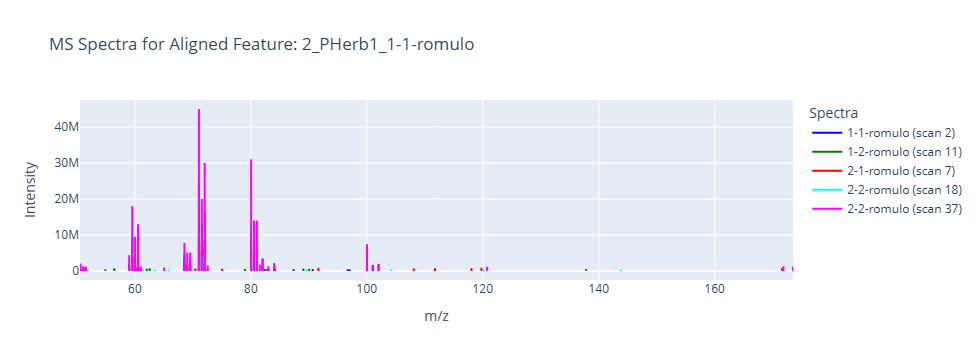

In [15]:
# Plot MS spectra for a specific feature
feature_batch = '2_PHerb1_1-1-romulo'
plot_ms_spectra(MSfiltered_aligned_features_df, feature_batch, spectra, project_prefix)

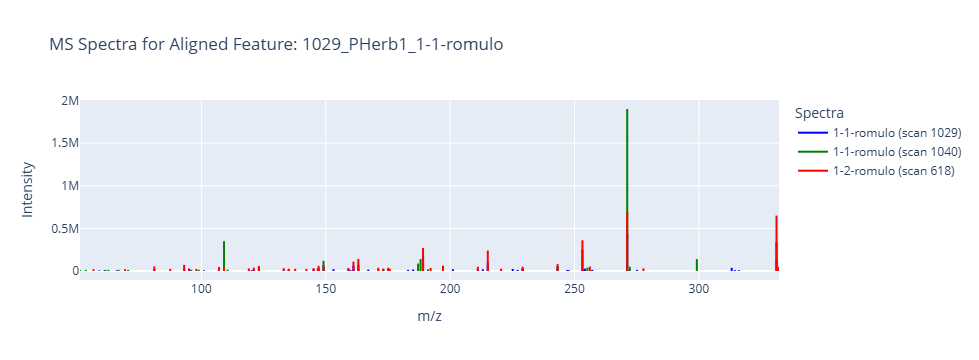

In [16]:
# Plot random MS spectra
plot_random_ms_spectra(MSfiltered_aligned_features_df, spectra, project_prefix)


---
#### Organize dataset

In [17]:
# Initialize a dictionary to store the combined classification row
classification_row = {'feature_info': 'group'}

# Loop through each file to process them
for file in file_paths:
    df = pd.read_csv(file)
    
    # Get the batch identifier from the filename
    filename = os.path.basename(file).replace('_MetaboAnalyst.csv', '')
    
    # Get the first row
    first_row = df.iloc[0].copy()
    
    # Append the batch identifier to each value in the first row
    for col in first_row.index:
        if col not in ['row ID', 'label']:  # Exclude non-sample columns
            classification_row[f"{filename}_{col}"] = first_row[col]

# Convert the combined row dictionary to a DataFrame with a single row
classification_combined = pd.DataFrame([classification_row])

# Replace NaN values with 0
classification_combined.fillna(0, inplace=True)

# Create the subdirectory if it doesn't exist
output_dir = os.path.join(directory_path, 'combined_results')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the modified DataFrame to the new subdirectory
output_file_path = os.path.join(output_dir, 'classification.csv')
classification_combined.to_csv(output_file_path, index=False)

print(f"Modified combined file saved at: {output_file_path}")

# Display the combined classification DataFrame
display(classification_combined)

Modified combined file saved at: C:\Users\PC Lab\Edison_Lab@UGA Dropbox\Ricardo Borges\Projeto_herbarium\Andrew Lab\Projeto herbário\MSMS - Amostras\Projeto_alinhamento\Processamento_romulo\batches\combined_results\classification.csv


,feature_info,PHerb1_1-1-romulo_Filename,PHerb1_1-1-romulo_6.mzML,PHerb1_1-1-romulo_16.mzML,PHerb1_1-1-romulo_12.mzML,PHerb1_1-1-romulo_13.mzML,PHerb1_1-1-romulo_3.mzML,PHerb1_1-1-romulo_20.mzML,PHerb1_1-1-romulo_15.mzML,PHerb1_1-1-romulo_10.mzML,...,PHerb1_2-2-romulo_125.mzML,PHerb1_2-2-romulo_MPCQExt_20231025090714.mzML,PHerb1_2-2-romulo_127.mzML,PHerb1_2-2-romulo_122.mzML,PHerb1_2-2-romulo_109.mzML,PHerb1_2-2-romulo_CQExt_20231027161607.mzML,PHerb1_2-2-romulo_MPCQExt_20231025030633.mzML,PHerb1_2-2-romulo_CQExt_20231027134303.mzML,PHerb1_2-2-romulo_CQExt_20231027105901.mzML,PHerb1_2-2-romulo_MPCQExt_20231027110958.mzML
0,group,group,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_CHAPOR,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,...,Paepalanthus trichophyllus_CHAes,MPCQExt,Paepalanthus trichophyllus_CHAes,Paepalanthus trichophyllus_CHAes,Paepalanthus trichophyllus_CHACRU,CQExt,MPCQExt,CQExt,CQExt,MPCQExt


In [18]:
# Identify the sample columns to keep
sample_columns = [col for col in MSfiltered_aligned_features_df.columns if col.endswith('.mzML') or col.endswith('.mzXML')]

# Create a new DataFrame with the concatenated 'scan_number', 'mz_value', 'rt_value' column and the sample columns
filtered_df = MSfiltered_aligned_features_df[sample_columns].copy()
filtered_df['feature_info'] = MSfiltered_aligned_features_df.apply(lambda row: f"{int(row['scan_number'])}_{row['mz_value']}_{row['rt_value']}", axis=1)

# Reorder columns to have 'feature_info' first
filtered_df = filtered_df[['feature_info'] + sample_columns]

# Replace all NaN values with zeros
filtered_df.fillna(0, inplace=True)

# Create the subdirectory if it doesn't exist
output_dir = os.path.join(directory_path, 'alignment_info_df')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the new DataFrame to a CSV file
output_file_path = os.path.join(output_dir, 'filtered_aligned_features.csv')
filtered_df.to_csv(output_file_path, index=False)

# Display the filtered DataFrame
pd.set_option("max_colwidth", None)
#display(filtered_df)

In [20]:
# Identify the sample columns to keep
sample_columns = [col for col in MSfiltered_aligned_features_df.columns if col.endswith('.mzML') or col.endswith('.mzXML')]

# Create a new DataFrame with the concatenated 'scan_number', 'mz_value', 'rt_value' column and the sample columns
filtered_df = MSfiltered_aligned_features_df[sample_columns].copy()
filtered_df['feature_info'] = MSfiltered_aligned_features_df.apply(lambda row: f"{int(row['scan_number'])}_{row['mz_value']}_{row['rt_value']}", axis=1)

# Reorder columns to have 'feature_info' first
filtered_df = filtered_df[['feature_info'] + sample_columns]

# Replace all NaN values with zeros
filtered_df.fillna(0, inplace=True)

# Initialize a dictionary to store the combined classification row
classification_row = {'feature_info': 'group'}

# Loop through each file to process them
for file in file_paths:
    df = pd.read_csv(file)
    
    # Get the batch identifier from the filename
    filename = os.path.basename(file).replace('_MetaboAnalyst.csv', '')
    
    # Get the first row
    first_row = df.iloc[0].copy()
    
    # Append the batch identifier to each value in the first row
    for col in first_row.index:
        if col not in ['row ID', 'label']:  # Exclude non-sample columns
            classification_row[f"{filename}_{col}"] = first_row[col]

# Create a classification row based on the sample columns of filtered_df
classification_data = {'feature_info': 'group'}
for col in sample_columns:
    for key in classification_row.keys():
        if key in col:
            classification_data[col] = classification_row[key]

# Convert the combined classification dictionary to a DataFrame with a single row
classification_df = pd.DataFrame([classification_data])

# Replace NaN values with zeros
classification_df.fillna(0, inplace=True)

# Combine classification_df as the first row of filtered_df
final_alignment_df = pd.concat([classification_df, filtered_df], ignore_index=True)

# Create the subdirectory if it doesn't exist
output_dir = os.path.join(directory_path, 'combined_results')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the modified DataFrame to the new subdirectory
output_file_path = os.path.join(output_dir, 'filtered_aligned_features_with_classification_MetaboAnalyst.csv')
final_alignment_df.to_csv(output_file_path, index=False)

print(f"Modified combined file saved at: {output_file_path}")

# Display the final DataFrame
pd.set_option("max_colwidth", None)
display(final_alignment_df)

Modified combined file saved at: C:\Users\PC Lab\Edison_Lab@UGA Dropbox\Ricardo Borges\Projeto_herbarium\Andrew Lab\Projeto herbário\MSMS - Amostras\Projeto_alinhamento\Processamento_romulo\batches\combined_results\filtered_aligned_features_with_classification_MetaboAnalyst.csv


,feature_info,df_PHerb1_1-1-romulo_6.mzML,df_PHerb1_1-1-romulo_16.mzML,df_PHerb1_1-1-romulo_12.mzML,df_PHerb1_1-1-romulo_13.mzML,df_PHerb1_1-1-romulo_3.mzML,df_PHerb1_1-1-romulo_20.mzML,df_PHerb1_1-1-romulo_15.mzML,df_PHerb1_1-1-romulo_10.mzML,df_PHerb1_1-1-romulo_39.mzML,...,df_PHerb1_2-2-romulo_125.mzML,df_PHerb1_2-2-romulo_MPCQExt_20231025090714.mzML,df_PHerb1_2-2-romulo_127.mzML,df_PHerb1_2-2-romulo_122.mzML,df_PHerb1_2-2-romulo_109.mzML,df_PHerb1_2-2-romulo_CQExt_20231027161607.mzML,df_PHerb1_2-2-romulo_MPCQExt_20231025030633.mzML,df_PHerb1_2-2-romulo_CQExt_20231027134303.mzML,df_PHerb1_2-2-romulo_CQExt_20231027105901.mzML,df_PHerb1_2-2-romulo_MPCQExt_20231027110958.mzML
0,group,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_CHAPOR,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_FLONA,Paepalanthus flaccidus_BABY,...,Paepalanthus trichophyllus_CHAes,MPCQExt,Paepalanthus trichophyllus_CHAes,Paepalanthus trichophyllus_CHAes,Paepalanthus trichophyllus_CHACRU,CQExt,MPCQExt,CQExt,CQExt,MPCQExt
1,2_83.5361_0.21,0,665364.5625,0,438936.5,532140.125,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3_153.0331_0.21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2333383.5
3,4_241.9999_0.21,644490.8125,1089360.125,0,1040891.9375,1098392.75,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5_130.0174_0.21,0,343931.6875,0,0,353365.28125,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,425_251.164_2.68,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
629,504_209.1546_3.53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,686184.125,0,0,0,0,0
630,508_353.2306_3.59,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1730002.875,0,0,0,0,0
631,584_279.1587_4.74,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2976240.25,0,0,0,0,0
